In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print("Bulunan GPU'lar:", gpus)

Bulunan GPU'lar: []


## Veri Setinin İndirilmesi

In [4]:
data = yf.download("^GSPC", start="2013-01-01", end="2025-05-03", auto_adjust=False)
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2013-01-02,1462.420044,1462.420044,1462.430054,1426.189941,1426.189941,4202600000
2013-01-03,1459.369995,1459.369995,1465.469971,1455.530029,1462.420044,3829730000
2013-01-04,1466.469971,1466.469971,1467.939941,1458.989990,1459.369995,3424290000
2013-01-07,1461.890015,1461.890015,1466.469971,1456.619995,1466.469971,3304970000
2013-01-08,1457.150024,1457.150024,1461.890015,1451.640015,1461.890015,3601600000


## Eksik veri kontrolü

In [6]:
if data.isnull().sum().sum() == 0:
    print("Eksik veri yok")
else:
    print("Eksik veri var")

Eksik veri yok


In [7]:
close_price = data["Close"].values
close_price = close_price.reshape(-1,1)
close_price

array([[1462.42004395],
       [1459.36999512],
       [1466.4699707 ],
       ...,
       [5569.06005859],
       [5604.14013672],
       [5686.66992188]])

In [8]:
print("Kapanış verisi sayısı= ", len(close_price))

Kapanış verisi sayısı=  3103


C:\Users\okand\AppData\Local\Temp\ipykernel_25092\344113319.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


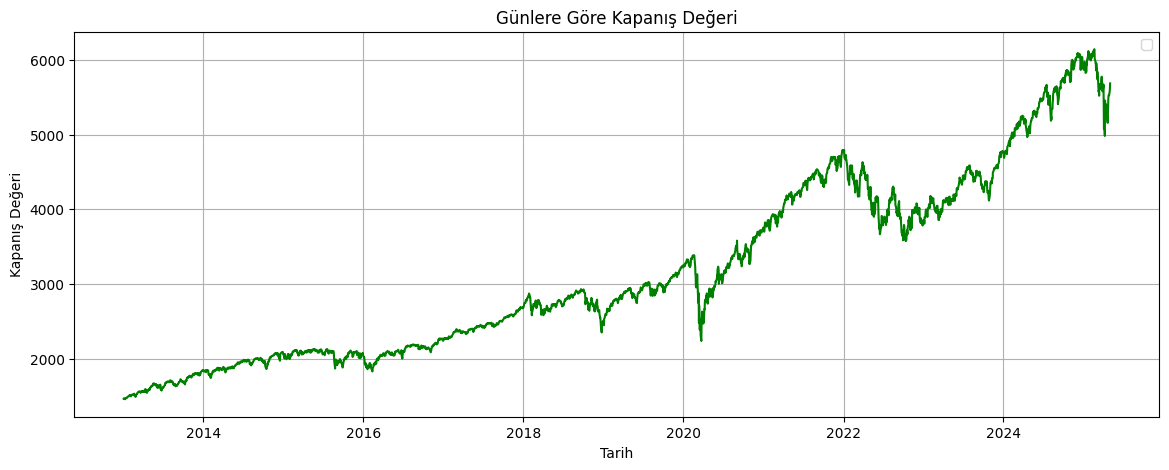

In [9]:
plt.figure(figsize=(14,5))
plt.plot(data["Close"], "green")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Değeri")
plt.title("Günlere Göre Kapanış Değeri")
plt.legend()
plt.grid()
plt.show()

## Verilerin 0-1 Arasına Yerleştirilmesi

In [11]:
sc = MinMaxScaler()
close_price_sc = sc.fit_transform(close_price)
close_price_sc

array([[1.12439080e-03],
       [4.73644284e-04],
       [1.98846736e-03],
       ...,
       [8.77301076e-01],
       [8.84785624e-01],
       [9.02393857e-01]])

## Veri setini 90 giriş ve 1 çıkış verisi olarak düzenlenmesi

In [13]:
def crate_dataset(array, step):
    X, y = [], []
    for i in range(len(array)):
        next_element = i + step
        if next_element > len(array) - 1:
            break
        else:
            x_values = array[i: next_element]
            y_value = array[next_element]
            X.append(x_values)
            y.append(y_value)
    return np.array(X), np.array(y)

In [14]:
step = 90
X_values, y_value = crate_dataset(close_price_sc, step)

In [15]:
print(len(X_values[0]))

90


In [16]:
X_values[0, 0:30]

array([[0.00112439],
       [0.00047364],
       [0.00198847],
       [0.00101131],
       [0.        ],
       [0.00082569],
       [0.00319393],
       [0.00317901],
       [0.00288671],
       [0.00324087],
       [0.00330275],
       [0.00507572],
       [0.00615105],
       [0.00755495],
       [0.008035  ],
       [0.00803711],
       [0.00977383],
       [0.00918072],
       [0.01081501],
       [0.00956047],
       [0.00873906],
       [0.01195221],
       [0.008227  ],
       [0.0115511 ],
       [0.01172818],
       [0.01114572],
       [0.01296779],
       [0.01277149],
       [0.01328782],
       [0.01347982]])

In [19]:
y_value[0]

array([0.03768295])

## Eğitim ve test setlerinin oluşturulması

In [22]:
train_size = int(len(X_values) * 0.80)

X_train, X_test = X_values[:train_size], X_values[train_size:]
y_train, y_test = y_value[:train_size], y_value[train_size:]

In [23]:
X_train.shape

(2410, 90, 1)

In [24]:
y_train.shape

(2410, 1)

## Çok Katmanlı LSTM Modeli Oluşturma

In [31]:
model = Sequential()
model.add(LSTM(50, return_sequences= True, input_shape=(90, 1)))
model.add(LSTM(50, return_sequences= True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer = "adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 90, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Model training
early_stopping = EarlyStopping(monitor = "val_loss", patience = 15, verbose = 1)
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
76/76 [==============================] - 31s 272ms/step - loss: 0.0051 - val_loss: 0.0020
Epoch 2/100
76/76 [==============================] - 17s 230ms/step - loss: 3.8770e-04 - val_loss: 0.0016
Epoch 3/100
76/76 [==============================] - 18s 240ms/step - loss: 3.5153e-04 - val_loss: 0.0015
Epoch 4/100
76/76 [==============================] - 18s 242ms/step - loss: 3.3866e-04 - val_loss: 0.0016
Epoch 5/100
76/76 [==============================] - 18s 234ms/step - loss: 3.6366e-04 - val_loss: 0.0016
Epoch 6/100
76/76 [==============================] - 19s 246ms/step - loss: 3.0506e-04 - val_loss: 0.0021
Epoch 7/100
76/76 [==============================] - 17s 222ms/step - loss: 3.0255e-04 - val_loss: 0.0018
Epoch 8/100
76/76 [==============================] - 17s 222ms/step - loss: 2.9041e-04 - val_loss: 6.6492e-04
Epoch 9/100
76/76 [==============================] - 18s 238ms/step - loss: 3.0159e-04 - val_loss: 6.3450e-04
Epoch 10/100
76/76 [======================

## Model Performansının Değerlendirilmesi:

In [52]:
def pred_and_score(model, X, y):
    predictions = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y,predictions))
    return rmse, predictions

rmse_train, train_predict = pred_and_score(model, X_train, y_train)
rmse_test, train_predict = pred_and_score(model, X_test, y_test)

print("Train score (RMSE): ", rmse_train)
print("Test score (RMSE): ", rmse_test)

19/19 [==============================] - 1s 74ms/step
Train score (RMSE):  0.011271860127402777
Test score (RMSE):  0.02893476906280727


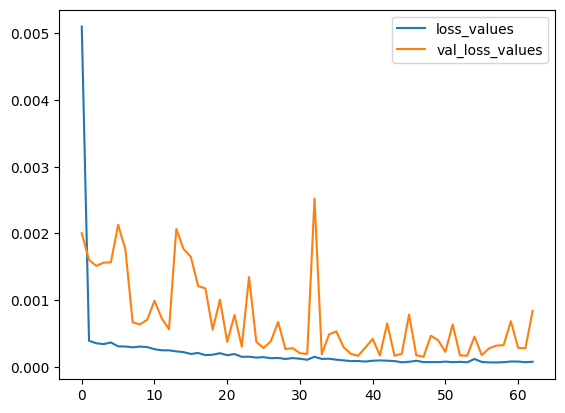

In [56]:
plt.plot(range(len(history.history["loss"])), history.history["loss"], label="loss_values")
plt.plot(range(len(history.history["val_loss"])), history.history["val_loss"], label="val_loss_values")
plt.legend()

In [58]:
true_x_values, _ = crate_dataset(close_price_sc, 90)
preds = model.predict(true_x_values)
preds = sc.inverse_transform(preds)

95/95 [==============================] - 7s 73ms/step


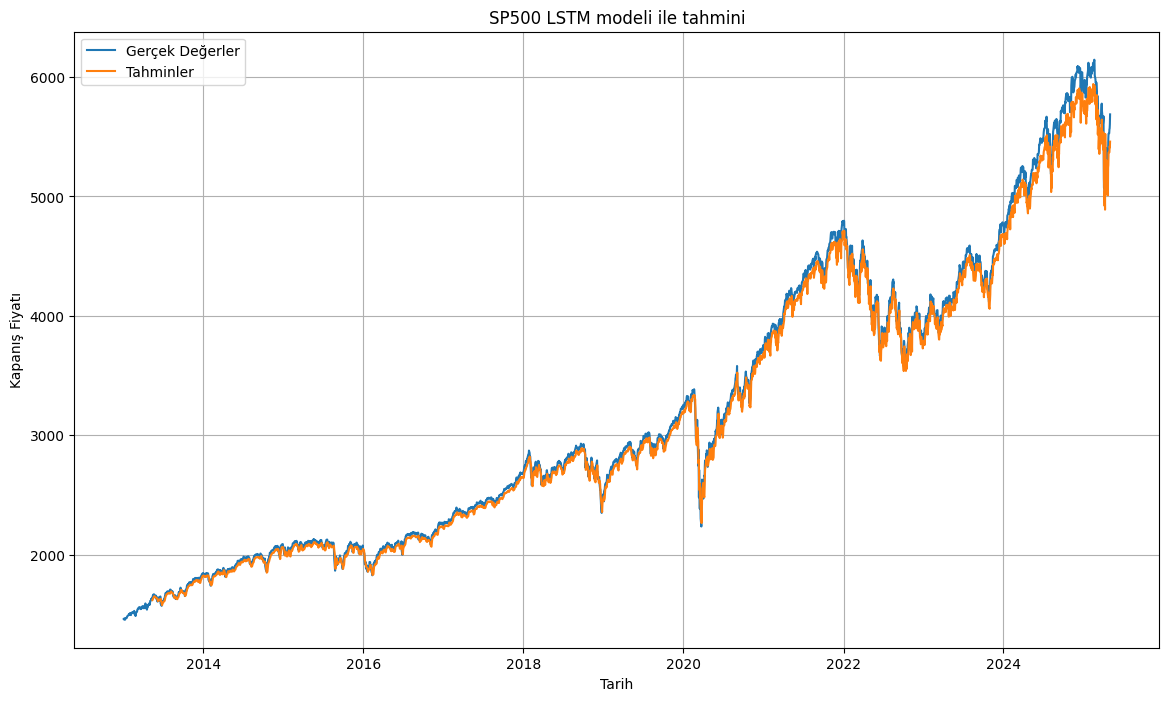

In [60]:
plt.figure(figsize=(14, 8))
plt.plot(data.index, sc.inverse_transform(close_price_sc), label='Gerçek Değerler')
plt.plot(data.index[step:], preds, label='Tahminler')
plt.title("SP500 LSTM modeli ile tahmini")
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı')
plt.legend()
plt.grid(True)
plt.show()

19/19 [==============================] - 1s 75ms/step


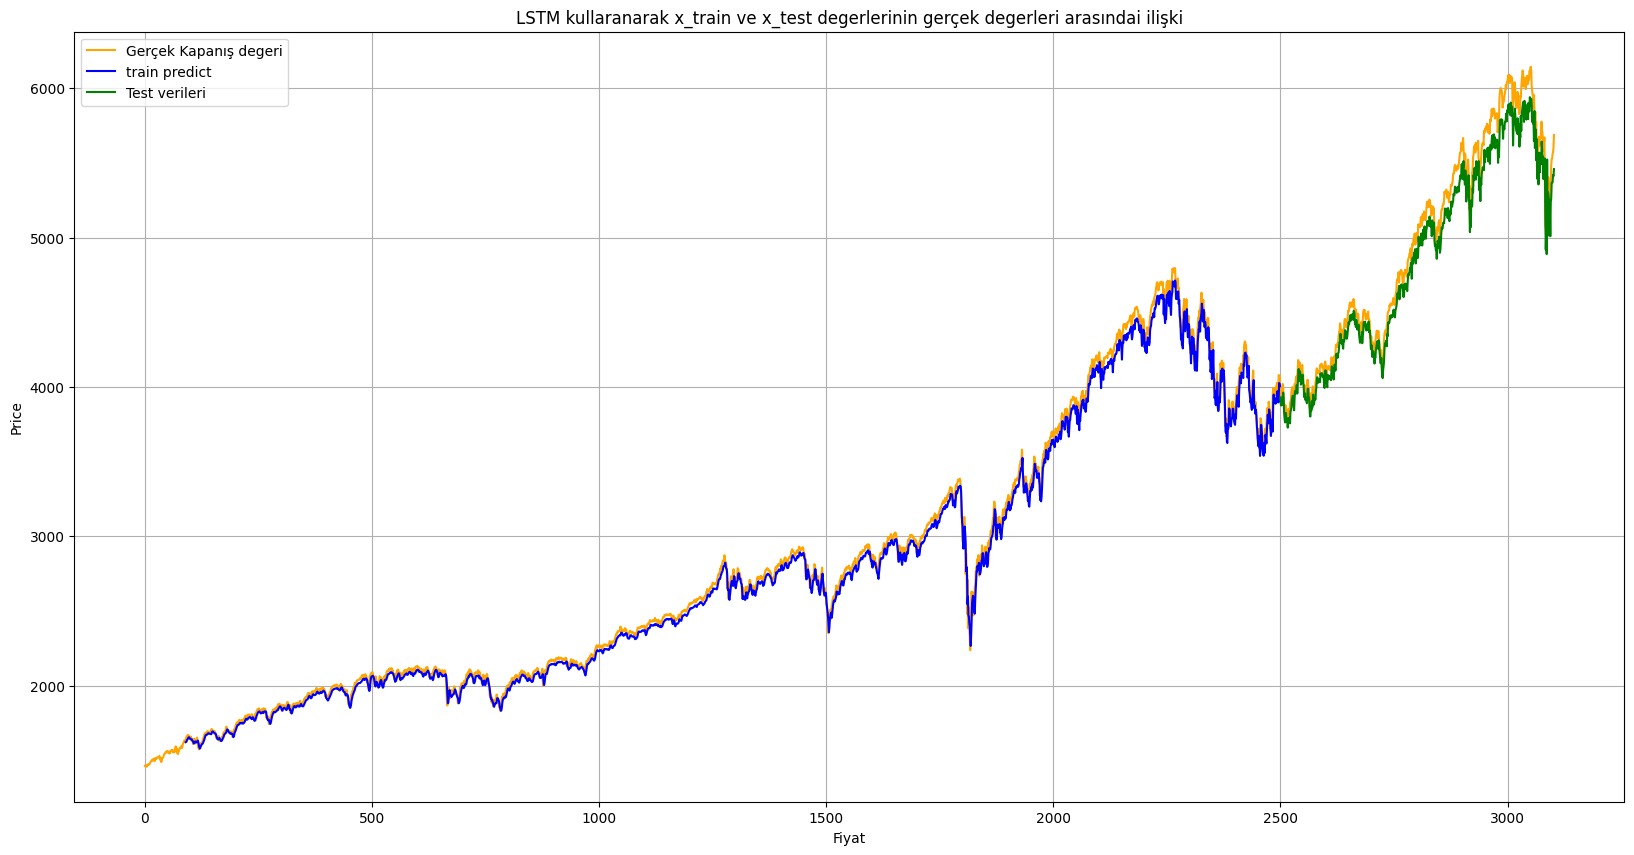

In [66]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = train_predict.reshape(-1, 1) if len(train_predict.shape) == 1 else train_predict
test_predict = test_predict.reshape(-1, 1) if len(test_predict.shape) == 1 else test_predict
train_predict = sc.inverse_transform(train_predict)
test_predict = sc.inverse_transform(test_predict)
steps = 90
plt.figure(figsize=(20,10))
plt.plot(sc.inverse_transform(close_price_sc), label="Gerçek Kapanış degeri", color="orange")
plt.plot(range(steps, len(train_predict) + steps), train_predict, label="train predict", color="blue")
plt.plot(range(steps + len(train_predict), steps + len(train_predict) + len(test_predict)), test_predict, label="Test verileri", color="green")
plt.title("LSTM kullaranarak x_train ve x_test degerlerinin gerçek degerleri arasındai ilişki")
plt.xlabel("Fiyat")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()